In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K

#------------用于绘制模型细节，可选--------------#
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#------------------------------------------------#

K.set_image_data_format('channels_first')

import time
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import fr_utils
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=10000000)

Using TensorFlow backend.
C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",



参数数量: 3743280


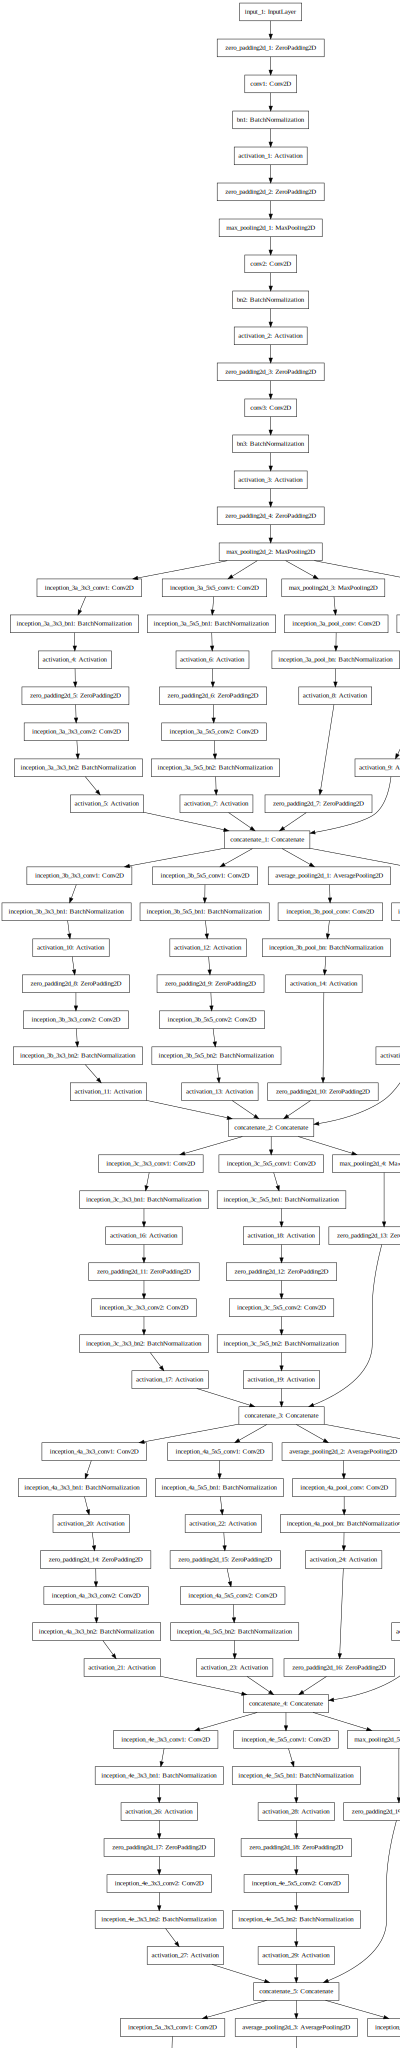

In [2]:
#获取模型
FRmodel = faceRecoModel(input_shape=(3,96,96))

#打印模型的总参数数量
print("参数数量: " + str(FRmodel.count_params()))

#------------用于绘制模型细节，可选--------------#
%matplotlib inline
plot_model(FRmodel, to_file='FRmodel.png')
SVG(model_to_dot(FRmodel).create(prog='dot', format='svg'))
#------------------------------------------------#

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    根据公式（4）实现三元组损失函数
    
    参数：
        y_true -- true标签，当你在Keras里定义了一个损失函数的时候需要它，但是这里不需要。
        y_pred -- 列表类型，包含了如下参数：
            anchor -- 给定的“anchor”图像的编码，维度为(None,128)
            positive -- “positive”图像的编码，维度为(None,128)
            negative -- “negative”图像的编码，维度为(None,128)
        alpha -- 超参数，阈值
    
    返回：
        loss -- 实数，损失的值
    """
    #获取anchor, positive, negative的图像编码
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    #1st step: 计算"anchor" 与 "positive"之间编码的距离,这里需要使用axis = -1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    #2nd step: 计算"anchor"与"negative"之间编码的距离,这里需要使用axis = -1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    #3rd step: 求和
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    
    #4th step: 比较basic_loss与0的大小，对训练样本的求和
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    
    return loss


#test
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3,128], mean=6, stddev=0.1, seed=1),
              tf.random_normal([3,128], mean=1, stddev=1,   seed=1),
              tf.random_normal([3,128], mean=3, stddev=4,   seed=1)
             )
    loss = triplet_loss(y_true,y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.1432


In [5]:
#开始时间
start_time = time.clock()

#编译模型
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

#加载权重
fr_utils.load_weights_from_FaceNet(FRmodel)

#结束时间
end_time = time.clock()

#计算时差
minium = end_time - start_time

print("执行了: " + str(int(minium / 60)) + "分" + str(int(minium % 60)) + "秒")

C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


执行了: 1分29秒


C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [6]:
database = {}
database["danielle"] = fr_utils.img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = fr_utils.img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = fr_utils.img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = fr_utils.img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = fr_utils.img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = fr_utils.img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = fr_utils.img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = fr_utils.img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = fr_utils.img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = fr_utils.img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = fr_utils.img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = fr_utils.img_to_encoding("images/arnaud.jpg", FRmodel)

In [11]:
def verify(image_path, identity, database, model):
    """
    对“identity”与“image_path”的编码进行验证。
    
    参数：
        image_path -- 摄像头的图片。
        identity -- 字符类型，想要验证的人的名字。
        database -- 字典类型，包含了成员的名字信息与对应的编码。
        model -- 在Keras的模型的实例。
        
    返回：
        dist -- 摄像头的图片与数据库中的图片的编码的差距。
        is_open_door -- boolean,是否该开门。
    """
    #1st step: 计算图像的编码
    encoding = fr_utils.img_to_encoding(image_path, model)
    
    #2nd step: 计算与数据库中保存的编码的差距
    dist = np.linalg.norm(encoding - database[identity])
    
    #3rd step: 判断是否打开了门
    if dist < 0.7:
        print("欢迎 " + str(identity) + "回家!")
        is_door_open = True
    else:
        print("经验证, 您与" + str(identity) + "不符!")
        is_door_open = False
        
    return dist, is_door_open

#test
verify("images/camera_0.jpg","younes",database,FRmodel)
#test
verify("images/camera_2.jpg", "kian", database, FRmodel)

欢迎 younes回家!
经验证, 您与kian不符!


(0.85868865, False)

In [16]:
def who_is_it(image_path, database,model):
    """
    根据指定的图片来进行人脸识别
    
    参数：
        images_path -- 图像地址
        database -- 包含了名字与编码的字典
        model -- 在Keras中的模型的实例。
        
    返回：
        min_dist -- 在数据库中与指定图像最相近的编码。
        identity -- 字符串类型，与min_dist编码相对应的名字。
    """
    #step1 : 计算指定图像的编码
    encoding = fr_utils.img_to_encoding(image_path, model)
    
    #step2 : 找到最相近的编码
    min_dist = 100
    
    ##遍历数据库找到最相近的编码
    for (name,db_enc) in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        
        #update
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    #如果小于阈值,认为找到了，反正没有找到
    if min_dist >0.7:
        print("抱歉, 您的信息不在数据库中。")
    else:
        print("姓名" + str(identity) + " 差距:" +str(min_dist))
    
    return min_dist, identity

#test
who_is_it("images/camera_0.jpg", database, FRmodel)

姓名younes 差距:0.6671406


(0.6671406, 'younes')